<a href="https://colab.research.google.com/github/shenzhun/machine-learning-prep/blob/master/tensorflow/day6_middle_level_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers

# Number of sample
n = 400

# Generating the datasets
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @ is matrix multiplication; adding Gaussian noise

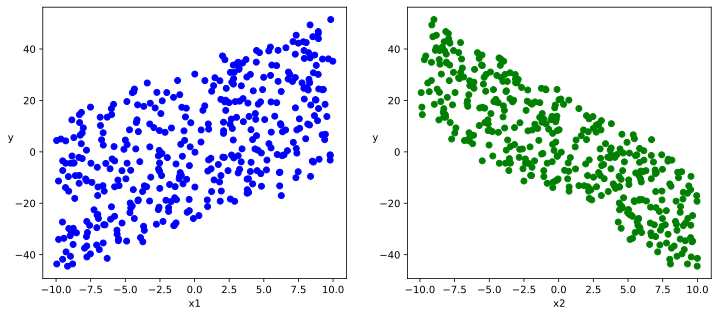

In [3]:
# Data Visualization
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [14]:
# Creating generator of data pipeline
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 100).batch(10) \
     .prefetch(tf.data.experimental.AUTOTUNE)  

In [20]:
model = layers.Dense(units=1)
model.build(input_shape = (2,))
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

In [21]:
@tf.function
def train_step(model, features, labels):
  with tf.GradientTape() as tape:
    predications = model(features)
    loss = model.loss_func(tf.reshape(labels, [-1]), tf.reshape(predications, [-1]))
  
  grads = tape.gradient(loss, model.variables)
  model.optimizer.apply_gradients(zip(grads, model.variables))
  return loss

# Testing the results of train_step
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=342.1363>

In [23]:
def train_model(model, epochs):
  for epoch in tf.range(1, epochs+1):
    loss = tf.constant(0.0)
    for features, labels in ds:
      loss = train_step(model, features, labels)
    
    if epoch%50 == 0:
      tf.print("epoch =", epoch, "loss =", loss)
      tf.print("w =", model.variables[0])
      tf.print("b =", model.variables[1])
train_model(model, epochs = 200)

epoch = 50 loss = 4.37419033
w = [[2.01749444]
 [-3.00472474]]
b = [2.99949837]
epoch = 100 loss = 3.70310211
w = [[2.00081277]
 [-3.021626]]
b = [3.00054669]
epoch = 150 loss = 2.36722946
w = [[2.01048684]
 [-3.00798178]]
b = [3.00180125]
epoch = 200 loss = 4.52352333
w = [[2.02157831]
 [-3.00980401]]
b = [3.00103474]


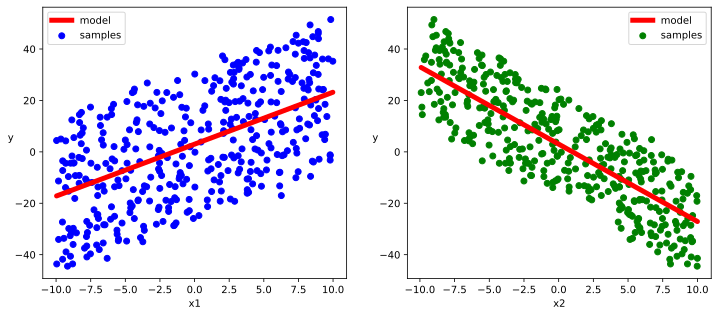

In [24]:
# Visualizing the results

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


DNN Binary Classification Model

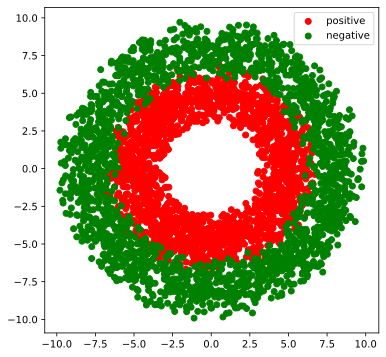

In [25]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Number of the positive/negative samples
n_positive,n_negative = 2000,2000

# Generating the positive samples with a distribution on a smaller ring
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

# Generating the negative samples with a distribution on a larger ring
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

# Assembling all samples
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


# Visualizing the data
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"])

In [35]:
# Create pipeline for the input data
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 4000).batch(100) \
     .prefetch(tf.data.experimental.AUTOTUNE) 

In [36]:
class DNNModel(tf.Module):
  def __init__(self, name = None):
    super(DNNModel, self).__init__(name=name)
    self.dense1 = layers.Dense(4, activation= "relu")
    self.dense2 = layers.Dense(8, activation= "relu")
    self.dense3 = layers.Dense(1, activation = "sigmoid")
  
  #FP
  @tf.function(input_signature=[tf.TensorSpec(shape = [None, 2], dtype = tf.float32)])
  def __call__(self, x):
    x = self.dense1(x)
    x = self.dense2(x)
    y = self.dense3(x)
    return y
  
model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate=0.001)

In [37]:
(features, labels) = next(ds.as_numpy_iterator())

predications = model(features)
loss = model.loss_func(tf.reshape(labels, [-1]), tf.reshape(predications, [-1]))
metric = model.metric_func(tf.reshape(labels, [-1]), tf.reshape(predications, [-1]))

tf.print("init loss:", loss)
tf.print("init metric", metric)

init loss: 0.90484792
init metric 0.47


In [38]:
# Transform to static graph for acceleration using Autograph

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    metric = model.metric_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    
    return loss,metric

# Testing the result of train_step
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.8136714>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.53>)

In [39]:
@tf.function
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0),tf.constant(0.0)
        for features, labels in ds:
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)
train_model(model,epochs = 60)

epoch = 10 loss =  0.603496075 accuracy =  0.65
epoch = 20 loss =  0.477891266 accuracy =  0.79
epoch = 30 loss =  0.277273297 accuracy =  0.94
epoch = 40 loss =  0.171124727 accuracy =  0.97
epoch = 50 loss =  0.218913704 accuracy =  0.91
epoch = 60 loss =  0.17775327 accuracy =  0.95


Text(0.5, 1.0, 'y_pred')

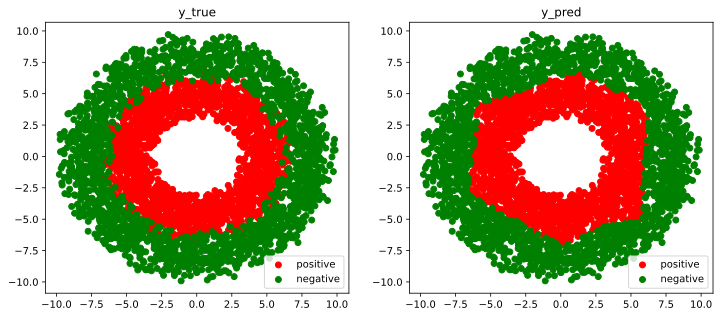

In [40]:
# Visualizing the results
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"])
ax2.set_title("y_pred")